## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration 

In [1]:
#Adding required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import cv2
import glob # To read all images inside a folder
import yaml

# Flag for debugging the output
DEBUG_ENABLED = 0    
CALIBRATE = 1 
# Write real world co-ordinates of the corners of the chess board.    
objp = np.zeros(((9*6),3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
     
# Lists for holding objects points and their image coordinates
imgpoints = []
objpoints = []

# This function return Grayscale image
def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# This function draws corners of the chess board on the color input image
def draw_chess_board_corners(ret, corners, img, objpoints, imgpoints):
    if (ret == True):
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        objpoints.append(objp)
        imgpoints.append(corners)
        if(DEBUG_ENABLED):
            plt.imshow(img, cmap ='gray')
            plt.title("ChessBoard Corner Image")
            plt.show()
        return objpoints, imgpoints

# This function calculates Camera matrix and Distortion coeffients 
def calibrate_camera(images):
    for image in images:
        img = plt_img.imread(image)
        gray = grayscale(img)
        if(DEBUG_ENABLED):
            plt.imshow(gray, cmap ='gray')
            plt.title("Grayscale image")
            plt.show()
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)    
        draw_chess_board_corners(ret, corners, img, objpoints, imgpoints)            
    #Calibrate camera     
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Returns Camera matrix (mtx) and Distortion coeffients (dist)
    return mtx, dist

def undistort_chessboard_images(images, mtx, dist):
    for image in images:
        img = plt_img.imread(image)
        # Un-distort images
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        if(DEBUG_ENABLED):
            plt.imshow(dst)
            plt.title("ChessBoard Corner Image")
            plt.show()

def undistort_images(image, mtx, dist):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    if(1):
        plt.imshow(dst)
        plt.title("ChessBoard Corner Image")
        plt.show()
    return dst

## Binary image creation
Use color transforms, gradients, etc., to create a thresholded binary image.

In [2]:
# Edit this function to create your own pipeline.
def binary_image_creation(img, sx_thresh=(20, 100), s_thresh=(170, 255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

## Perspective Transform ("birds-eye view").

In [3]:
 def perspective_transform(src, dst, undist_image):
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    img_size = (undist_image.shape[1], undist_image.shape[0])
    warped = cv2.warpPerspective(undist_image, M, img_size)
    if(1):
        plt.imshow(warped)
        plt.title("Birds-eye view")
        plt.show()
    return warped    

## Detect lane pixels and fit to find the lane boundary.

In [4]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin # Update this
        
        # Draw the windows on the visualization image
        print(win_xleft_low,win_y_low)
        print(win_xleft_high,win_y_high)
        print(win_xright_low,win_y_low)
        print(win_xright_high,win_y_high) 
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&
        (nonzerox >= win_xleft_low)&(nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds =((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&
        (nonzerox >= win_xright_low)&(nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print("left_fit =", left_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #print("left_fitx =", left_fitx)
        #print("ploty =", ploty)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty



    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

## Start point of the pipeline

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

2. Use color transforms, gradients, etc., to create a thresholded binary image.

3. Apply a perspective transform to rectify binary image ("birds-eye view").

4. Detect lane pixels and fit to find the lane boundary.

5. Determine the curvature of the lane and vehicle position with respect to center.

6. Warp the detected lane boundaries back onto the original image.

7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

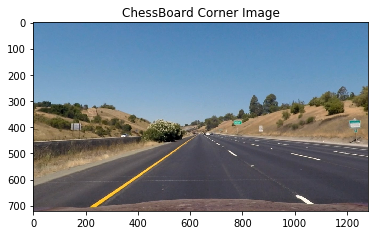

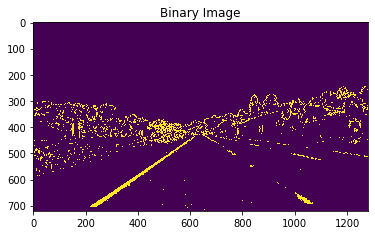

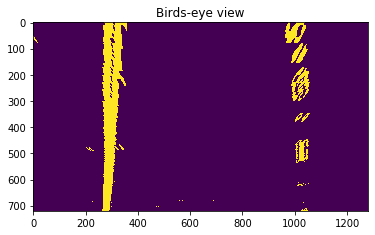

midpoint 640
leftx_base 276
rightx_base 1031
176 640
376 720
931 640
1131 720
182 560
382 640
935 560
1135 640
187 480
387 560
927 480
1127 560
190 400
390 480
925 400
1125 480
194 320
394 400
929 320
1129 400
195 240
395 320
926 240
1126 320
197 160
397 240
916 160
1116 240
203 80
403 160
926 80
1126 160
203 0
403 80
917 0
1117 80


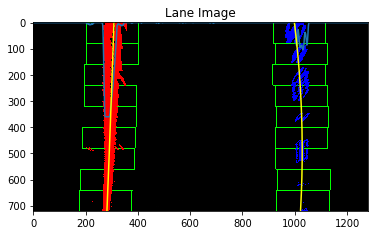

In [5]:
        
if (__name__== '__main__' ):
    # Read all images from a folder
    images = glob.glob("camera_cal/*.jpg")
    
    if (CALIBRATE):
        # Calibrate Camera
        mtx, dist = calibrate_camera(images)   
        
    # Undistort Chess Images
    if(DEBUG_ENABLED):
        undistort_chessboard_images(image, mtx, dist)
    
    # Undistort Test Images
    image = plt_img.imread("test_images/straight_lines1.jpg")
    undistorted_image = undistort_images(image, mtx, dist)
    
    # Binary image creation
    binay_image = binary_image_creation(undistorted_image, sx_thresh=(20, 100), s_thresh=(170, 255))
    if(1):
        plt.imshow(binay_image)
        plt.title("Binary Image")
        plt.show()        
    
    # Pixel points on the road in the input image
    src = np.float32([[260, 670], [590, 450], [690, 450], [1041, 670]])
    
    # Points where the input image is to be transformed
    dst = np.float32([[260, 719], [260, 0], [1050, 0], [1050, 719]])
    
    # # Perspective Transformation  
    binary_warped = perspective_transform(src, dst, binay_image)    
    
    # Detect lane pixels and fit to find the lane boundary.
    out_img = fit_polynomial(binary_warped)
    if(1):
        plt.imshow(out_img)
        plt.title("Lane Image")
        plt.show()
   